In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
import random

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,roc_curve, auc

plt.style.use('fivethirtyeight')

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)

/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
input_df = pd.read_csv("Datasets/bank-full.csv")
print(input_df.head())
print("==" * 40)
print(input_df.info())
print("==" * 40)
print(input_df.describe())
print("==" * 40)
print(input_df.shape)

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
ag

In [3]:
def target_var_distribution(df):
    '''
    find out the ratio among the unique values of the target variable
    
    Argument:
    df -- name of the dataframe
    
    Return:
    A void method but a fig is plotted showing the distribution of unique values of target variable in a pie chart 
    when the method is invoked
    '''
    print(df['y'].shape)
    f, ax= plt.subplots(1,2,figsize=(18,8))
    df['y'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax = ax[0], shadow= True)
    ax[0].set_title('Subscribed')
    ax[0].set_ylabel(' ')
    print(df[df.y == 'yes'].shape, df[df.y == 'no'].shape, df[df.y == np.nan].shape)
    sns.countplot('y', data = df, ax = ax[1])
    ax[1].set_title('y')
    plt.show()

(45211,)
(5289, 17) (39922, 17) (0, 17)


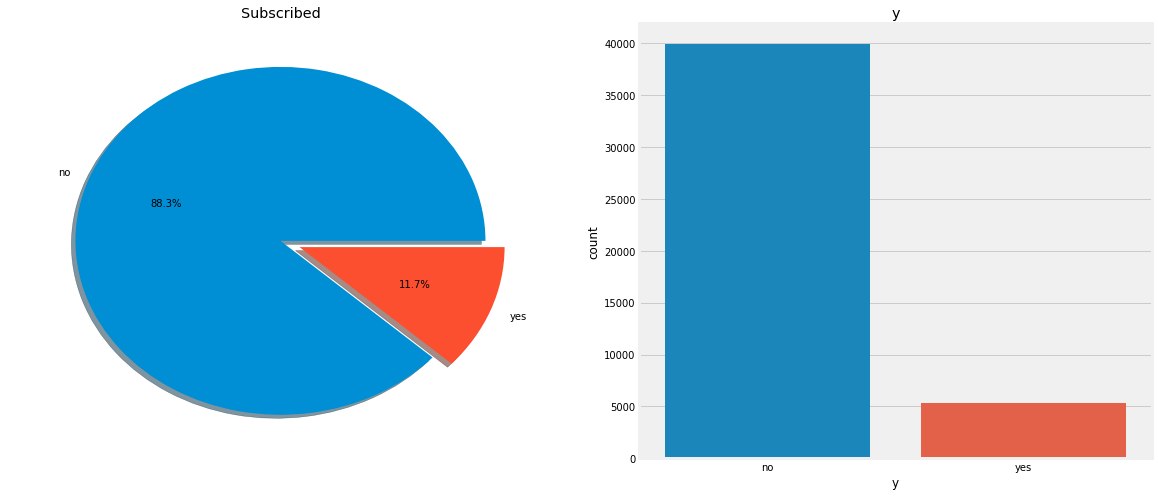

In [4]:
target_var_distribution(input_df)

In [5]:
def find_category_columns(df):
    '''
    find out the category column from the given dataframe
    Steps:
        1. find out the numerical columns
        2. set minus operation from dataframe columns to numerical columns
    Argument:
    df -- name of the dataframe
    
    Return:
    category_cols -- name of the category columns
    
    '''
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    category_cols = list(set(cols) - set(num_cols))
    return category_cols

In [6]:
find_category_columns(input_df)

['loan',
 'poutcome',
 'housing',
 'month',
 'marital',
 'y',
 'education',
 'default',
 'job',
 'contact']

Observation of category columns:

no. of category columns = 10

total columns = 17

In [7]:
def find_null_values_present_or_not_with_number(df):
    '''
    Check whether data frame has Nan values or not 
    
    Argument:
    df -- name of the dataframe
    
    Returns:
    
    a tuple of (boolean value whether null value is present, total null values present in the dataframe,
    show where null value present in the dataframe)
    '''
    return (df.isnull().values.any(), df.isnull().values.sum(), df.isnull().sum)

In [8]:
null_values_present_or_not, total_no_of_values, where_null_values_exists = find_null_values_present_or_not_with_number(input_df)

print(null_values_present_or_not)
if null_values_present_or_not > 0:
    print (total_no_of_values)
    if (total_no_of_values <0):
        print (where_null_values_exists)

False


In [9]:
def show_missing_values(input_df_check):
    '''
    To check whether the null value is present on any dataframe
    
    Steps:
        1. First find whether dataframe has null values or not
        2. create a dataframe containing two columns:
            a) name of the column
            b) number of missing values
        3. Draw a horizontal bar plotted  
    Arguments:
    input_df_check -- Name of the dataframe
    
    Return:
    A void method but a fig is plotted showing the total number of null values present in the column of a dataframe
    when the method is invoked
    '''
    missing_df = input_df_check.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.ix[missing_df['missing_count']>0]
    ind = np.arange(missing_df.shape[0])
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,18))
    rects = ax.barh(ind, missing_df.missing_count.values, color='y')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation= 'horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


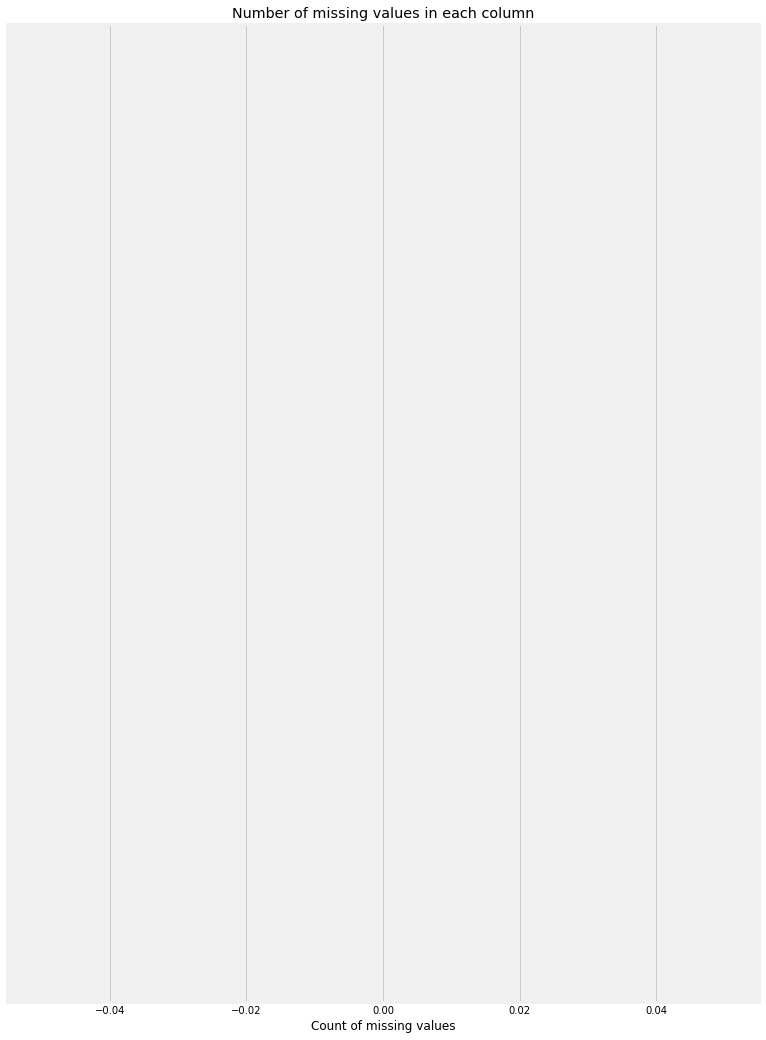

In [10]:
show_missing_values(input_df)

__OBSERVATION__

No null value is present on the dataset

In [11]:
def relationship_between_category_variables_target_variable(categ_var):
    '''
    Find out the relationship among category variables to target variables
    "group by" operation is done pivoting the category variable
    plot the visualization to show the relationship between category variables to target variable
    
    Arguments:
    categ_var -- name of the category variable
    
    Returns:
    A void method but a fig is plotted showing the relationship when the method is invoked
    '''
    print(input_df.groupby([categ_var,'y'])['y'].count())
    print("***" * 37)
    f,ax=plt.subplots(1,2,figsize=(18,8), gridspec_kw = {'width_ratios':[1, 3]})
    input_df[[categ_var,'y']].groupby([categ_var]).count().plot.bar(ax=ax[0])
    ax[0].set_title('' + categ_var + ' vs Subscribed deposit')
    sns.countplot(categ_var,hue='y',data=input_df,ax=ax[1])
    ax[1].set_title(''+ categ_var +':Subscribed vs Not Subscribed')
    plt.show()

job            y  
admin.         no     4540
               yes     631
blue-collar    no     9024
               yes     708
entrepreneur   no     1364
               yes     123
housemaid      no     1131
               yes     109
management     no     8157
               yes    1301
retired        no     1748
               yes     516
self-employed  no     1392
               yes     187
services       no     3785
               yes     369
student        no      669
               yes     269
technician     no     6757
               yes     840
unemployed     no     1101
               yes     202
unknown        no      254
               yes      34
Name: y, dtype: int64
***************************************************************************************************************


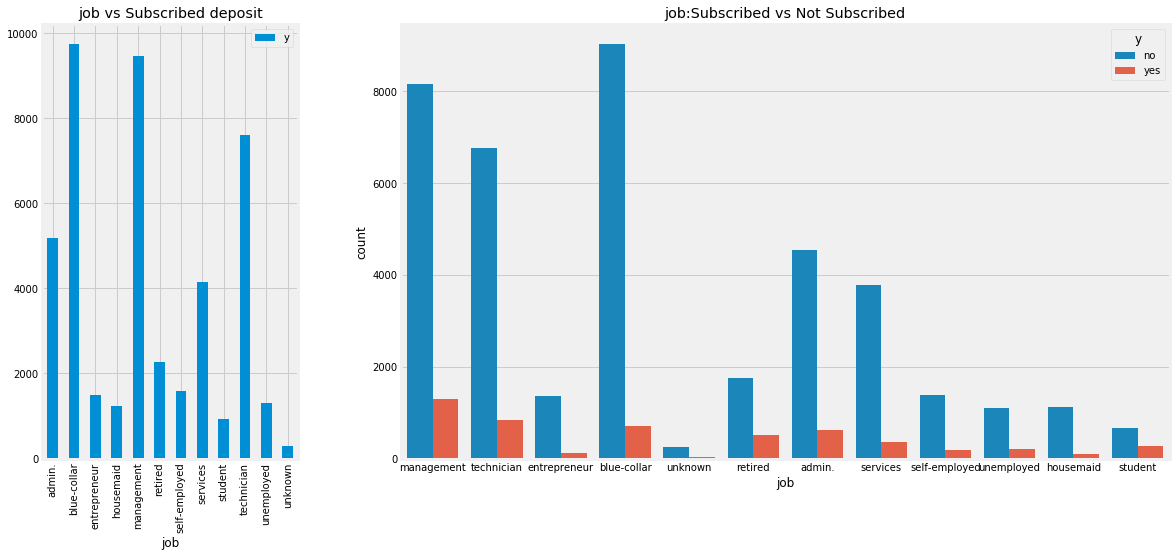

***************************************************************************************************************
***************************************************************************************************************
marital   y  
divorced  no      4585
          yes      622
married   no     24459
          yes     2755
single    no     10878
          yes     1912
Name: y, dtype: int64
***************************************************************************************************************


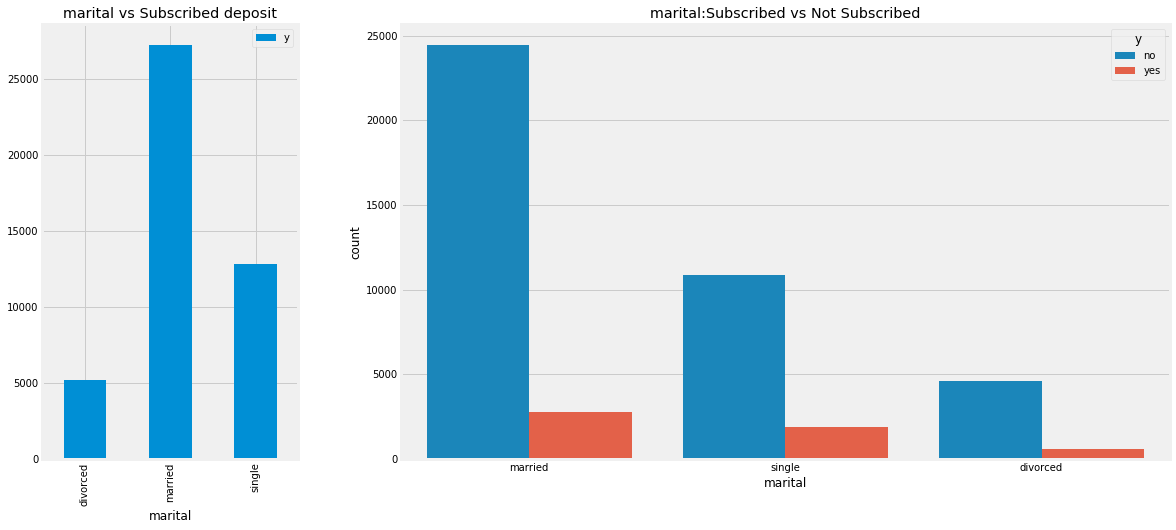

***************************************************************************************************************
***************************************************************************************************************
education  y  
primary    no      6260
           yes      591
secondary  no     20752
           yes     2450
tertiary   no     11305
           yes     1996
unknown    no      1605
           yes      252
Name: y, dtype: int64
***************************************************************************************************************


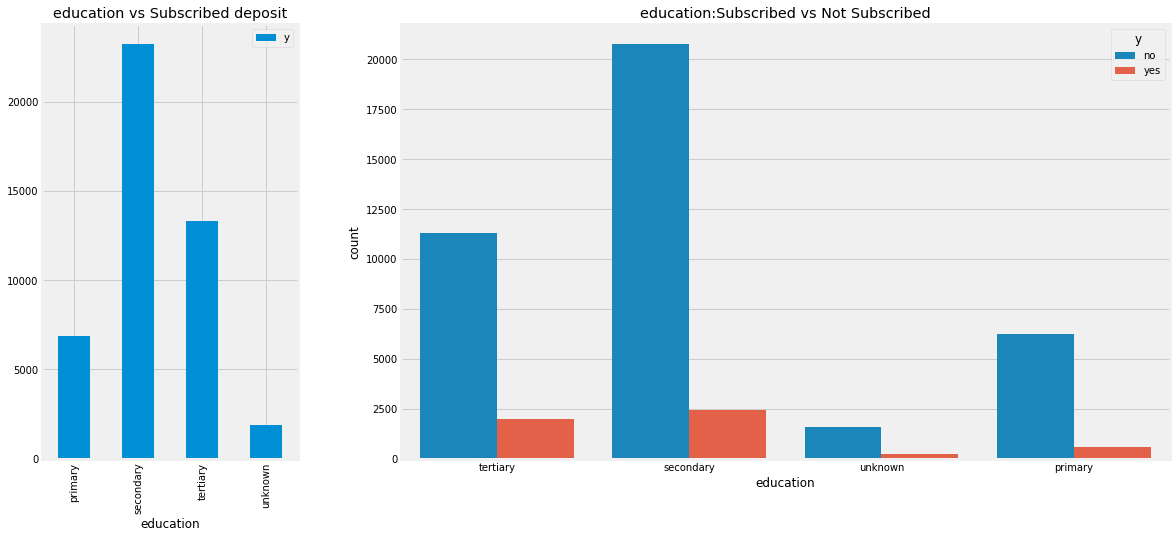

***************************************************************************************************************
***************************************************************************************************************
default  y  
no       no     39159
         yes     5237
yes      no       763
         yes       52
Name: y, dtype: int64
***************************************************************************************************************


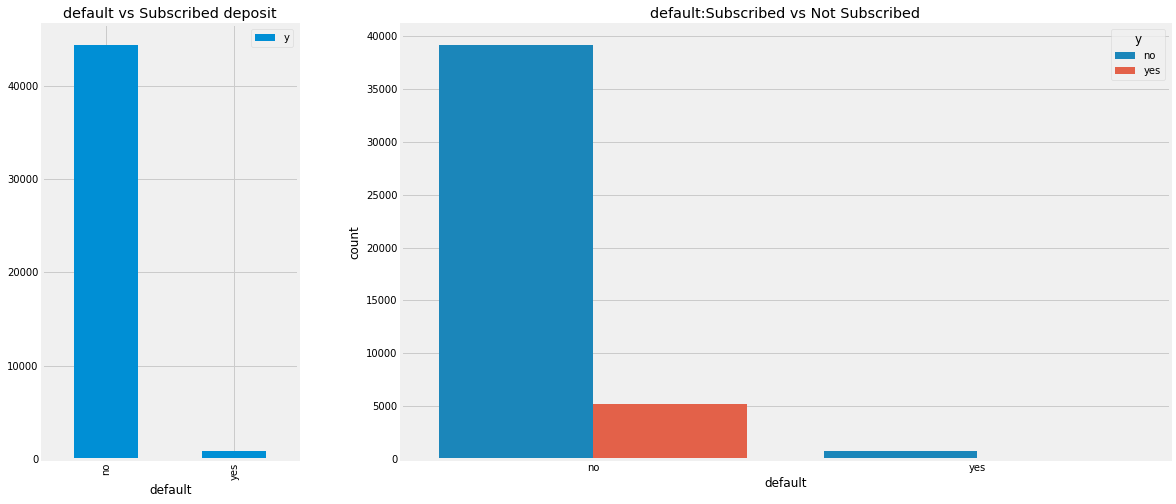

***************************************************************************************************************
***************************************************************************************************************
housing  y  
no       no     16727
         yes     3354
yes      no     23195
         yes     1935
Name: y, dtype: int64
***************************************************************************************************************


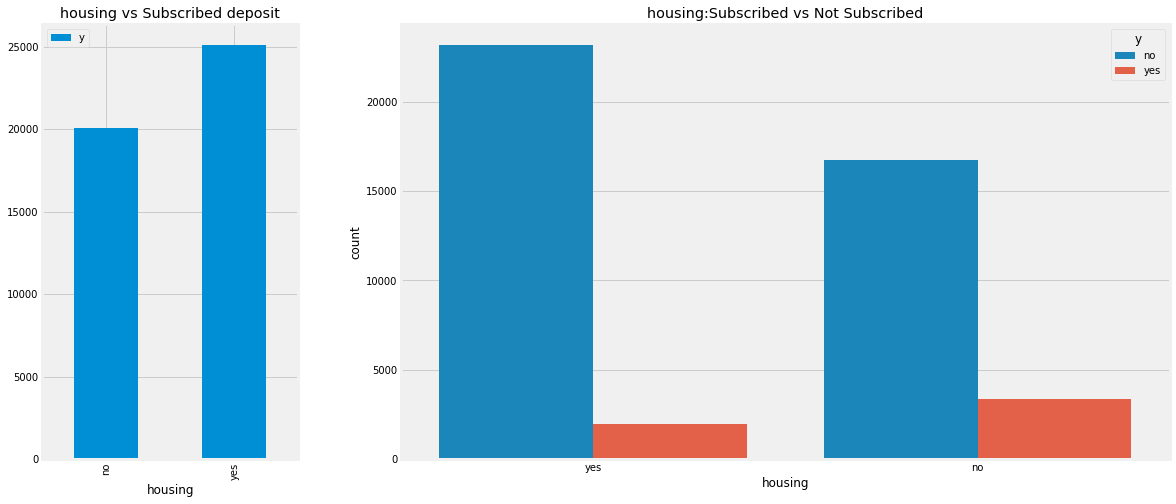

***************************************************************************************************************
***************************************************************************************************************
loan  y  
no    no     33162
      yes     4805
yes   no      6760
      yes      484
Name: y, dtype: int64
***************************************************************************************************************


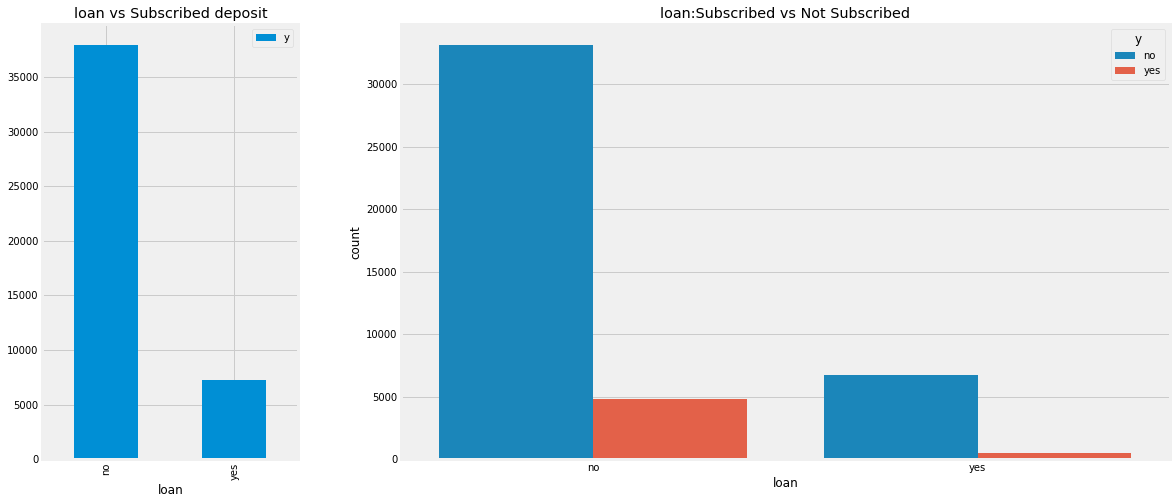

***************************************************************************************************************
***************************************************************************************************************
contact    y  
cellular   no     24916
           yes     4369
telephone  no      2516
           yes      390
unknown    no     12490
           yes      530
Name: y, dtype: int64
***************************************************************************************************************


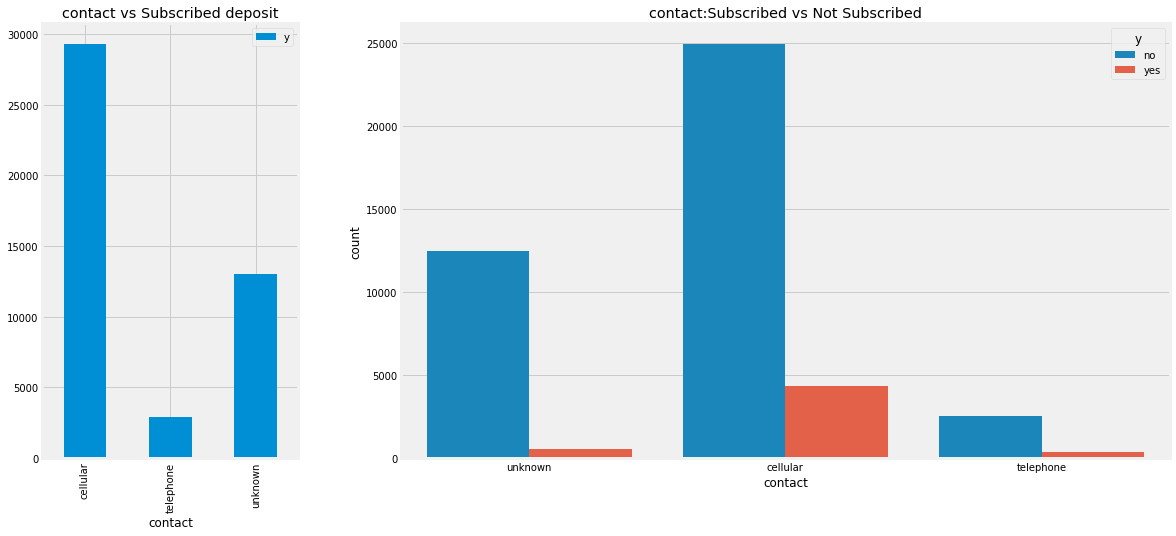

***************************************************************************************************************
***************************************************************************************************************
month  y  
apr    no      2355
       yes      577
aug    no      5559
       yes      688
dec    no       114
       yes      100
feb    no      2208
       yes      441
jan    no      1261
       yes      142
jul    no      6268
       yes      627
jun    no      4795
       yes      546
mar    no       229
       yes      248
may    no     12841
       yes      925
nov    no      3567
       yes      403
oct    no       415
       yes      323
sep    no       310
       yes      269
Name: y, dtype: int64
***************************************************************************************************************


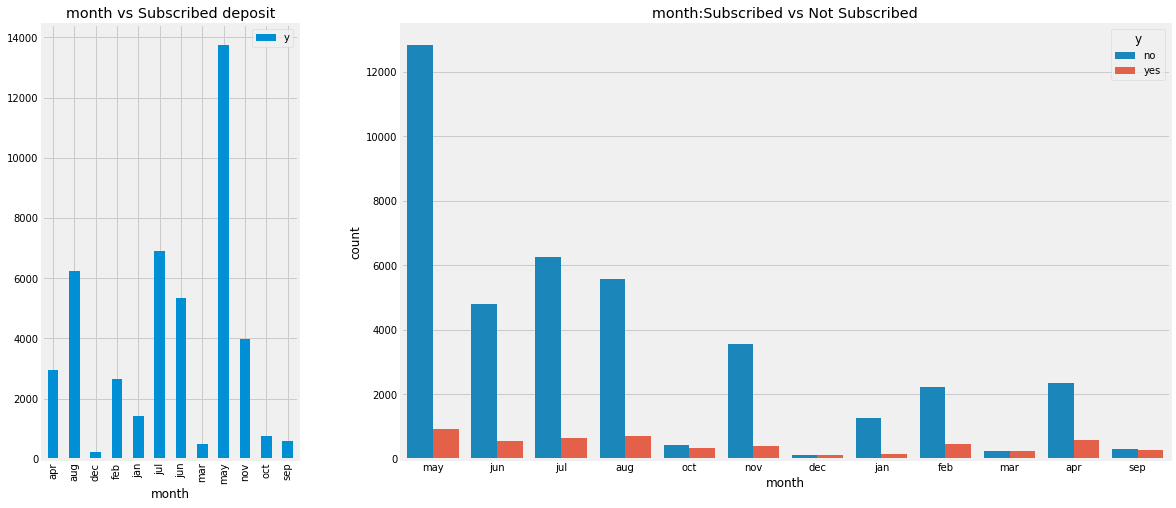

***************************************************************************************************************
***************************************************************************************************************
poutcome  y  
failure   no      4283
          yes      618
other     no      1533
          yes      307
success   no       533
          yes      978
unknown   no     33573
          yes     3386
Name: y, dtype: int64
***************************************************************************************************************


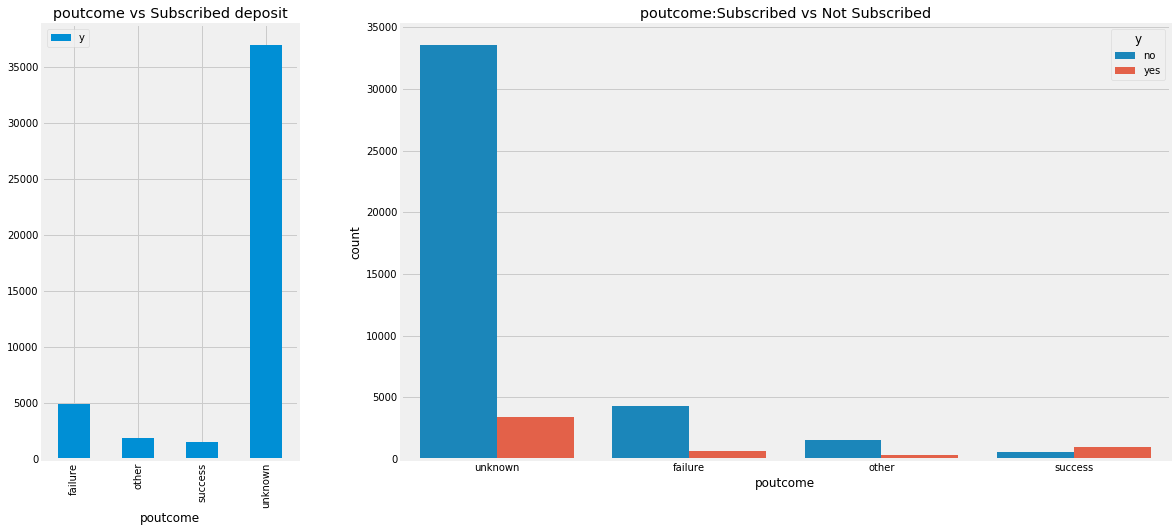

In [12]:
relationship_between_category_variables_target_variable('job')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('marital')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('education')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('default') # has credit in default? (categorical: 'no','yes','unknown')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('housing') # housing: has housing loan? (categorical: 'no','yes','unknown')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('loan') #loan: has personal loan? (categorical: 'no','yes','unknown')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('contact') #contact: contact communication type (categorical: 'cellular','telephone') 
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('month') # month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
print("***" * 37)
print("***" * 37)
relationship_between_category_variables_target_variable('poutcome') # poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [13]:
def convertcategorytoNumericalData(df):
    '''
    Convert the categorical dataframe into numerical dataframe
    
    Argument:
    df -- name of the dataframe
    
    Return:
    imp_df -- a dataframe replacing the category values into numerical values
    '''
    imp_df = df

    for f in imp_df.columns:
        if imp_df[f].dtype== 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(imp_df[f].values))
            imp_df[f] = lbl.transform(list(imp_df[f].values))
            
    return imp_df

In [14]:
def findCorrAmongData(input_df):
    '''
    
    Method calculating the correlation among the datas and plot it in a figure
    
    Arguments:
    input_df -- name of the dataframe
    
    Returns:
    A void method but draw a fig of having the relationship among data
    '''
    imp_df = convertcategorytoNumericalData(input_df)
    sns.heatmap(imp_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
    fig=plt.gcf()
    fig.set_size_inches(18,8)
    plt.show()

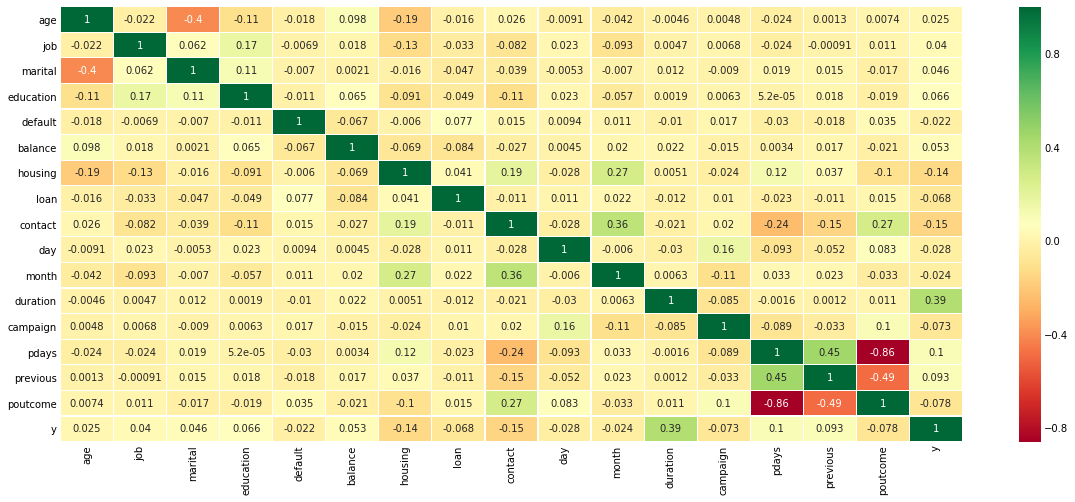

In [15]:
findCorrAmongData(input_df)

#### Corelation Matrix

- +1 means strongly positively corelated
- -1 means strongly negative corelated
- 0 means no realtiona at all

As observed, previous has strong pos relation with the pdays where pdays has neg relation with poutcome

## Skew of dataset

__Defintion__: Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point

- The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. 
- Negative values for the skewness indicate data that are skewed left. By skewed left, we mean that the left tail is long relative to the right tail
- positive values for the skewness indicate data that are skewed right. Similarly, skewed right means that the right tail is long relative to the left tail.
- If the data are multi-modal, then this may affect the sign of the skewness

In [16]:
input_df.skew().reset_index().sort_values([0], ascending= False)

,index,0
14,previous,41.846454
5,balance,8.360308
4,default,7.245375
12,campaign,4.898650
11,duration,3.144318
13,pdays,2.615715
16,y,2.383480
7,loan,1.852617
8,contact,0.769381
0,age,0.684818


__Observation:__ 

Clearly, previous is right skewed where day is the most symmetic one 

/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


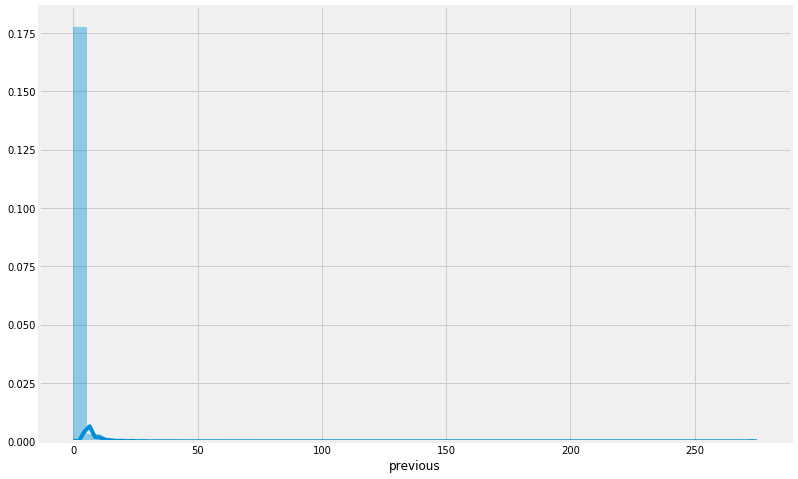

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(input_df.previous.values, bins=50, kde= True)
plt.xlabel('previous', fontsize= 12)
plt.show()

as found, most of the values are 0 therefore logarithm will give us infinity. It wil not help much because we have to either replace with the infinite values with the biased value or we need to drop the values.

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


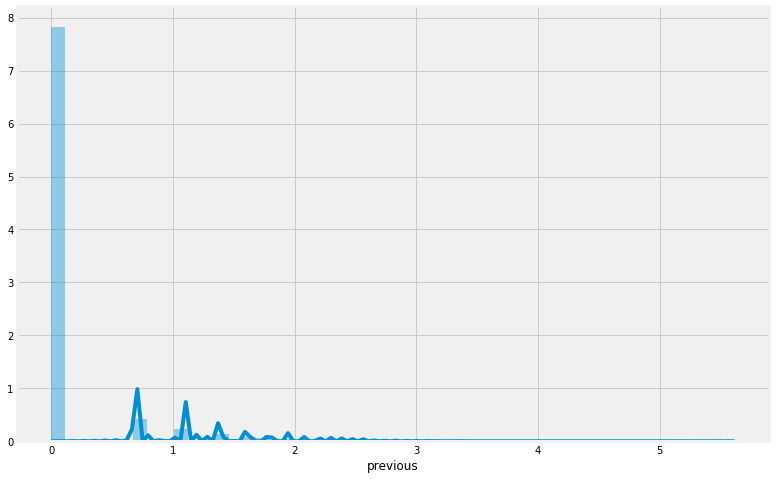

In [18]:
input_df_logarithm_values = np.log(input_df.previous).to_frame()
input_df_logarithm_values = input_df_logarithm_values.replace([np.inf, -np.inf], 0)
plt.figure(figsize=(12,8))
sns.distplot(input_df_logarithm_values, bins= 50, kde= True)
plt.xlabel('previous', fontsize = 12)
plt.show()

In [19]:
def findImpFeatures(df):
    '''
    
    Find out the importance features of the datasets using one of the ensemble methods.
    
    Arguments:
    df = name of the given dataframe
    
    Returns:
    A void method but draw a fig of important features 
    '''
    
    imp_df = convertcategorytoNumericalData(df)
        
    train_y = imp_df.y.values
    train_X = imp_df.drop(["y"], axis=1)

    xgb_params = {
        'eta': 0.05,
        'max_depth': 8,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric' : 'rmse',
        'silent': 1
    }

    dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

    fig, ax = plt.subplots(figsize=(12,18))
    xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
    plt.show()

[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned no

[11:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=8
[11:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned no

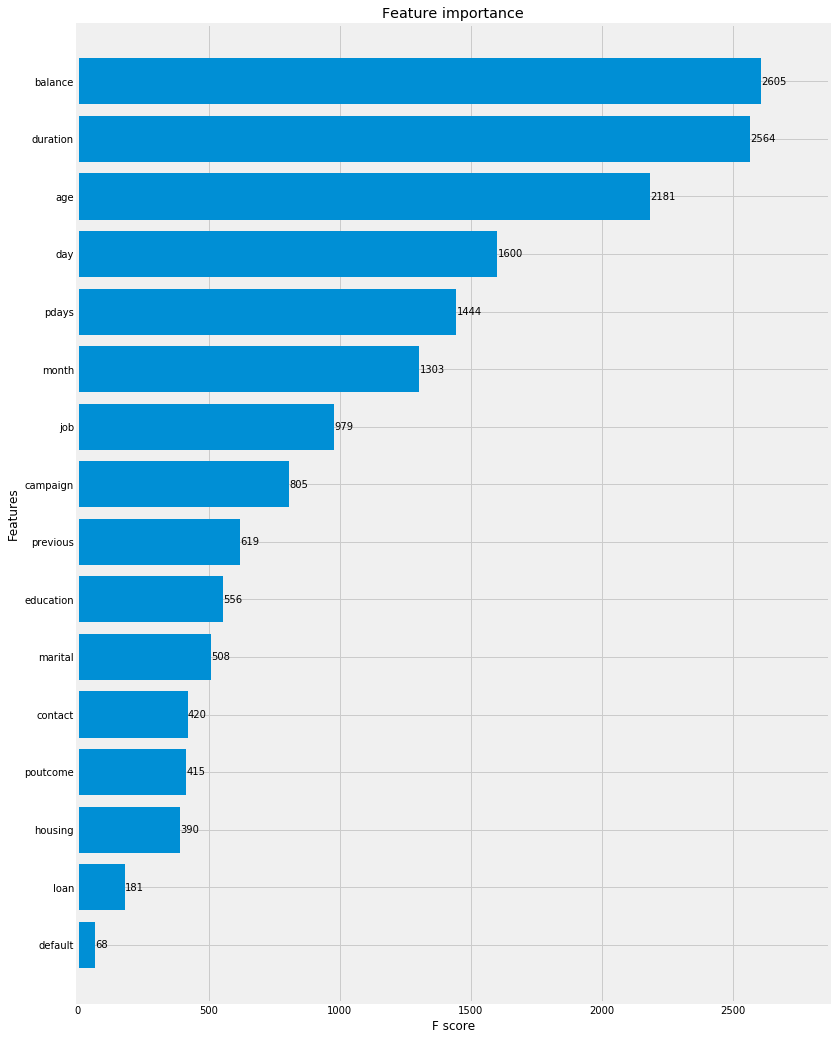

In [20]:
findImpFeatures(input_df)

The top 3 important features are:

1. balance
2. duration
3. age

In [21]:
def relationship_between_range_continuos_var_with_target_variable(df,predictor):
    '''
    Implements the relationship between range continuous var with target
    
    Steps: 
        1. Print the max, min and average values
        2. Convert the numerical values into a frequency interval(bins) 
        3. The no of total bins are calculated by "Sturges law"
        4. Draw the image
        
    Arguments: 
    df -- name of the dataframe
    predictor -- the name of the column of the dataframe
    
    Returns:
    
    a void method but when the method is invoked the relationship is visualized 
    '''
    dftobeOperated = df[predictor]
    print("**"*50)
    print("**" *23,predictor,"**" *23)
    print("**"*50)
    print('Max value ::',dftobeOperated.max())
    print('Min value ::',dftobeOperated.min())
    print('Average value::',dftobeOperated.mean())
    print(input_df.groupby([pd.cut(dftobeOperated, (1+3.322)*np.log(dftobeOperated.shape[0])), 'y'])['y'].count())
    f,ax=plt.subplots(2,1,figsize=(18,18))
    f.subplots_adjust(hspace=.35)
    frequency_interval = pd.Series(pd.cut(dftobeOperated, (1+3.322)*np.log(dftobeOperated.shape[0]))).unique().get_values()
    frequency_interval_count = input_df.groupby(pd.cut(dftobeOperated, frequency_interval.shape[0]))[predictor].count().values
    sns.barplot(np.sort(frequency_interval), frequency_interval_count, alpha=0.8, ax=ax[0])
    ax[0].set_title('' + predictor + ' vs Subscribed deposit')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    #plt.xticks(rotation = 'vertical')
    input_df.groupby([pd.cut(dftobeOperated, (1+3.322)*np.log(dftobeOperated.shape[0])), 'y'])['y'].count().plot.bar(ax=ax[1])
    ax[1].set_title(''+ predictor +':Subscribed vs Not Subscribed')
    plt.show()

****************************************************************************************************
********************************************** balance **********************************************
****************************************************************************************************
Max value :: 102127
Min value :: -8019
Average value:: 1362.2720576850766
balance                 y
(-8129.146, -5624.522]  0        2
(-5624.522, -3230.043]  0        3
(-3230.043, -835.565]   0      234
                        1        9
(-835.565, 1558.913]    0    30864
                        1     3551
(1558.913, 3953.391]    0     5489
                        1     1107
(3953.391, 6347.87]     0     1699
                        1      324
(6347.87, 8742.348]     0      751
                        1      130
(8742.348, 11136.826]   0      311
                        1       72
(11136.826, 13531.304]  0      194
                        1       43
(13531.304, 15925.783]  0      106
 

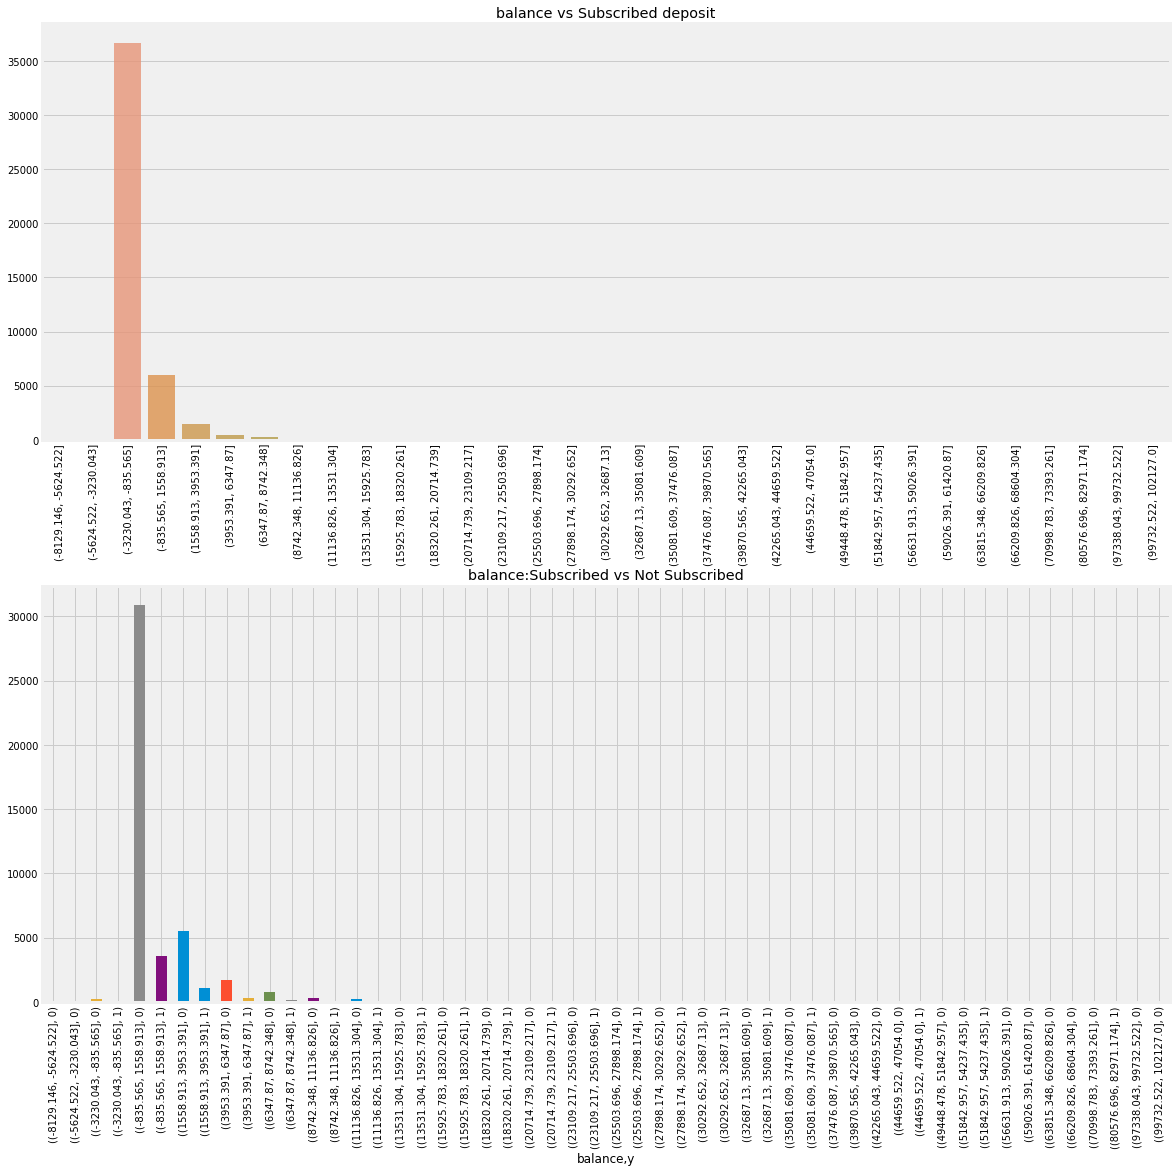

In [22]:
relationship_between_range_continuos_var_with_target_variable(input_df,'balance')

****************************************************************************************************
********************************************** duration **********************************************
****************************************************************************************************
Max value :: 4918
Min value :: 0
Average value:: 258.1630797814691
duration              y
(-4.918, 106.913]     0    11723
                      1      142
(106.913, 213.826]    0    13479
                      1      880
(213.826, 320.739]    0     6815
                      1      955
(320.739, 427.652]    0     3497
                      1      678
(427.652, 534.565]    0     1783
                      1      524
(534.565, 641.478]    0     1026
                      1      452
(641.478, 748.391]    0      563
                      1      418
(748.391, 855.304]    0      361
                      1      285
(855.304, 962.217]    0      206
                      1      253
(962.217, 

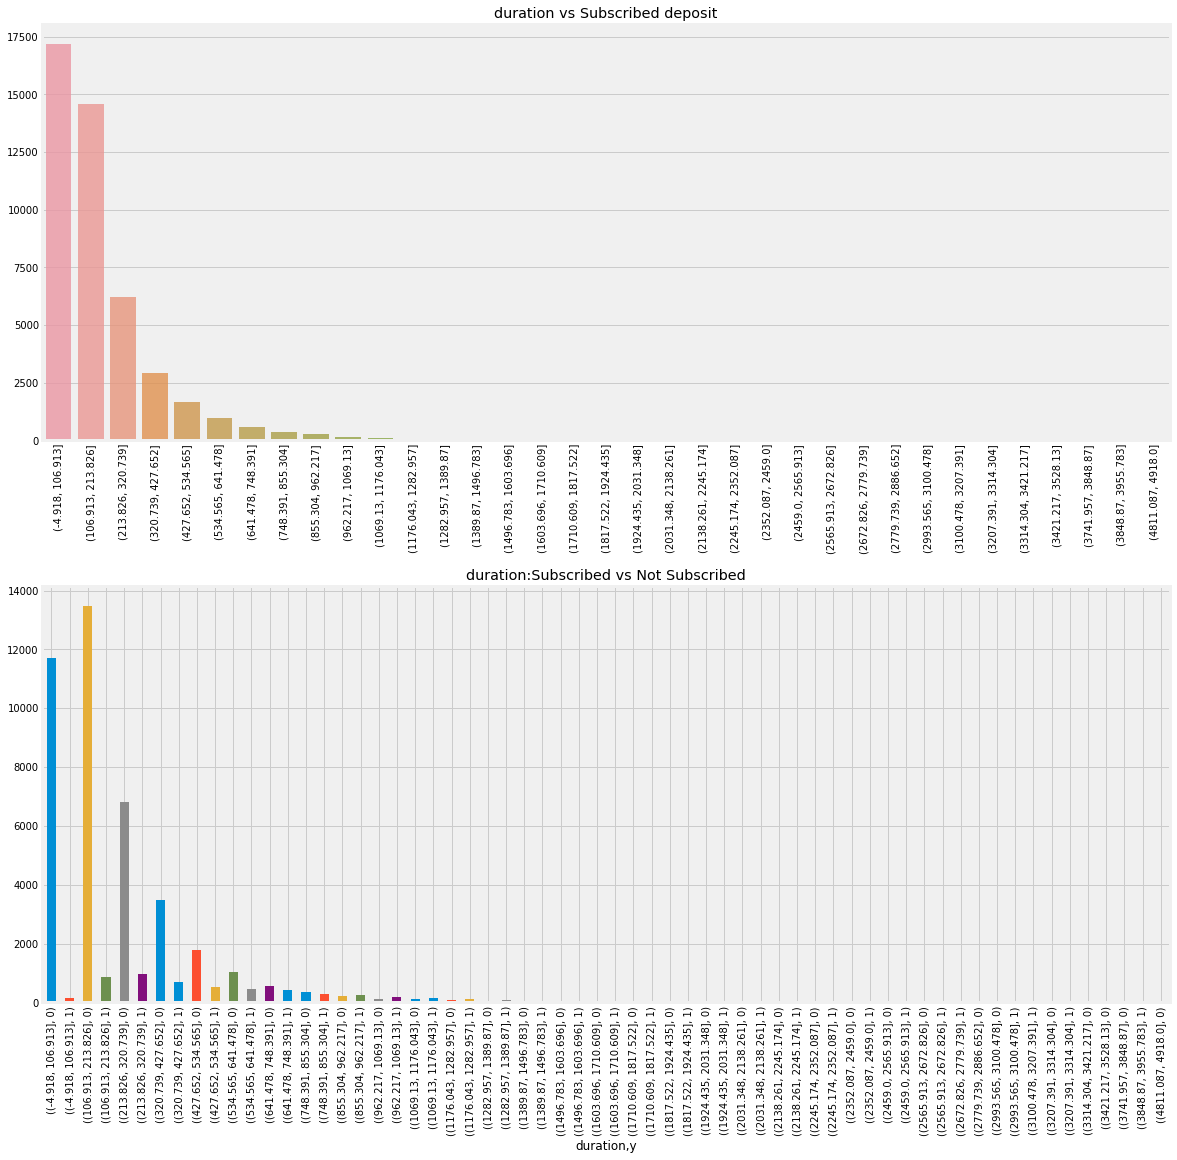

In [23]:
relationship_between_range_continuos_var_with_target_variable(input_df, 'duration')

****************************************************************************************************
********************************************** age **********************************************
****************************************************************************************************
Max value :: 95
Min value :: 18
Average value:: 40.93621021432837
age               y
(17.923, 19.674]  0      29
                  1      18
(19.674, 21.348]  0      92
                  1      37
(21.348, 23.022]  0     247
                  1      84
(23.022, 24.696]  0     234
                  1      68
(24.696, 26.37]   0    1085
                  1     247
(26.37, 28.043]   0    1644
                  1     303
(28.043, 29.717]  0    1014
                  1     171
(29.717, 31.391]  0    3330
                  1     423
(31.391, 33.065]  0    3626
                  1     431
(33.065, 34.739]  0    1732
                  1     198
(34.739, 36.413]  0    3296
                  1     40

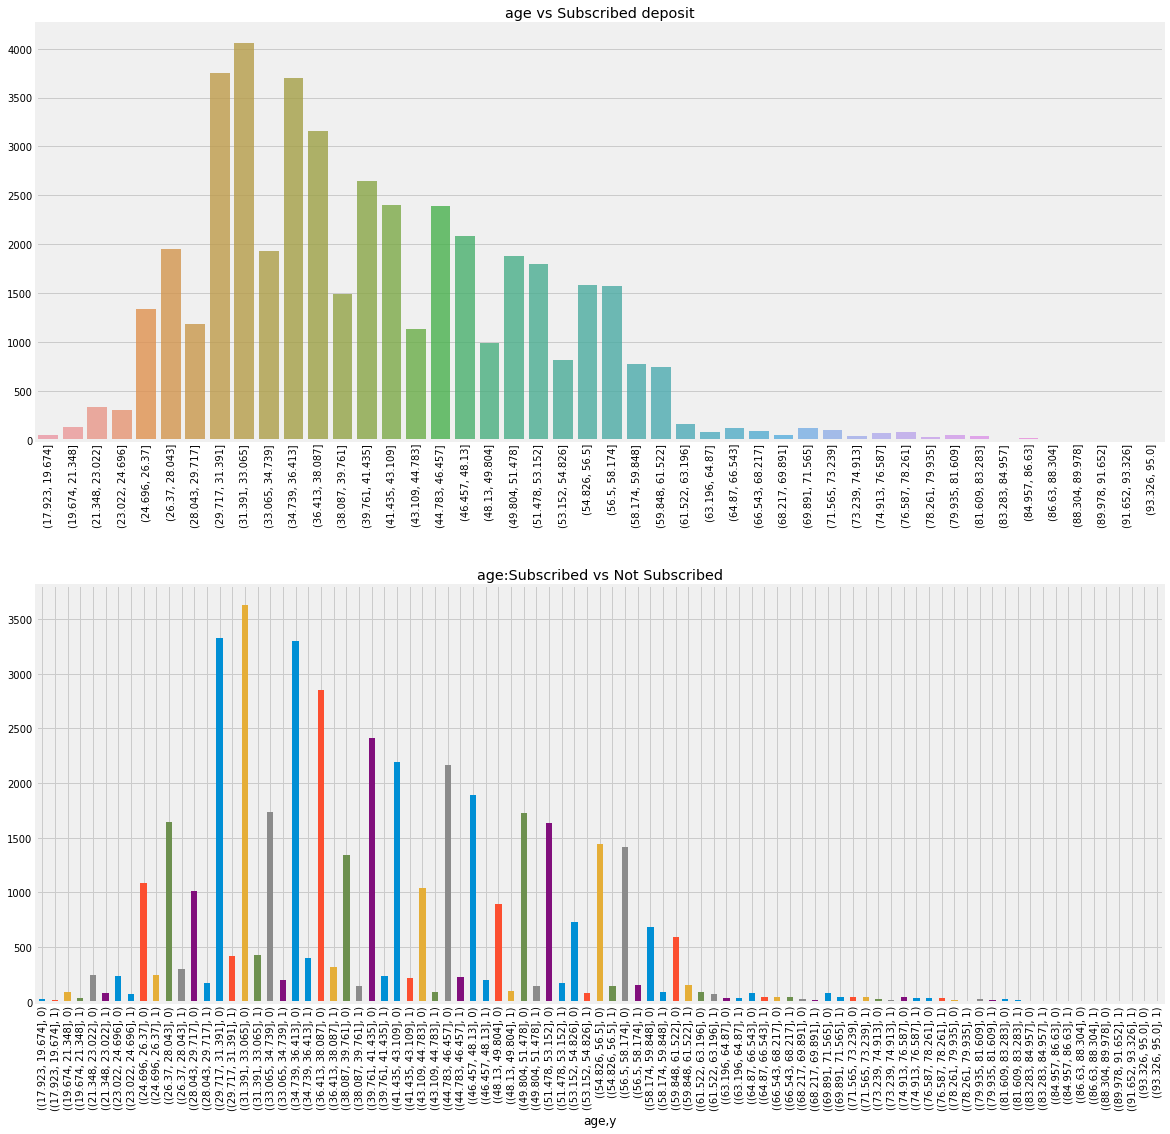

In [24]:
relationship_between_range_continuos_var_with_target_variable(input_df, 'age')

## AddNoise(just for learning purposes)

1. Raise an error if we want to insert nan into an int type column of a dataframe; hence it is for learning purpose therfore, forecfully we will reject the nan value for an int type column. That's why it should be ensured that this operation must took place before convert into numerical values

2. 10% of data converts into noise data


In [50]:
def add_noise(df):
    '''
    
    Add randomly null values to the selected position 
    Prerequisite:
        1. In category column, if we want to put nan an error will rise an error; "cannot convert float NaN to 
        integer "
            * 2 ways to tackle this situation: either convert category columns to integer column or find out the 
            numerical columns and then if the random position falls into that particular column then set the value
        2. We choose only to put the values into category columns forcefully
        
    Arguments:
    df -- name of the dataframe
    
    Returns:
    input_nan_present_df -- a dataframe containing "Nan" values 
    '''
    input_nan_present_df = df
    num_cols = input_nan_present_df._get_numeric_data().columns
    numeric_list = []
    ## put the numeric columns to a list
    for i in input_df._get_numeric_data().columns.tolist():
        numeric_list.append(input_df.columns.get_loc(i))
    #input_nan_present_df = convertcategorytoNumericalData(input_nan_present_df)
    ix = [(row, col) for row in range(input_nan_present_df.shape[0]) for col in range(input_nan_present_df.shape[1])]
    for row, col in random.sample(ix, int(round(.1*len(ix)))):
        if col not in numeric_list:
            print ('yes')
            input_nan_present_df.iat[row, col] = np.nan    
    return input_nan_present_df 

In [58]:
## do it for learning purpose. when running the notebook for classification purpose please avoid it
input_df = add_noise(input_df)
find_null_values_present_or_not_with_number(input_df)

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


(True,
 85630,
 <bound method DataFrame.sum of          age    job  marital  education  default  balance  housing   loan  \
 0      False  False     True      False    False    False    False  False   
 1      False   True    False      False     True    False    False  False   
 2      False  False    False      False    False    False    False  False   
 3      False  False    False      False    False    False    False  False   
 4      False  False    False      False    False    False    False  False   
 5      False  False    False       True    False    False    False  False   
 6      False  False    False      False    False    False    False  False   
 7      False  False    False      False    False    False    False   True   
 8      False  False    False      False    False    False    False   True   
 9      False  False     True      False    False    False    False  False   
 10     False  False    False      False     True    False    False   True   
 11     False  Fal

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


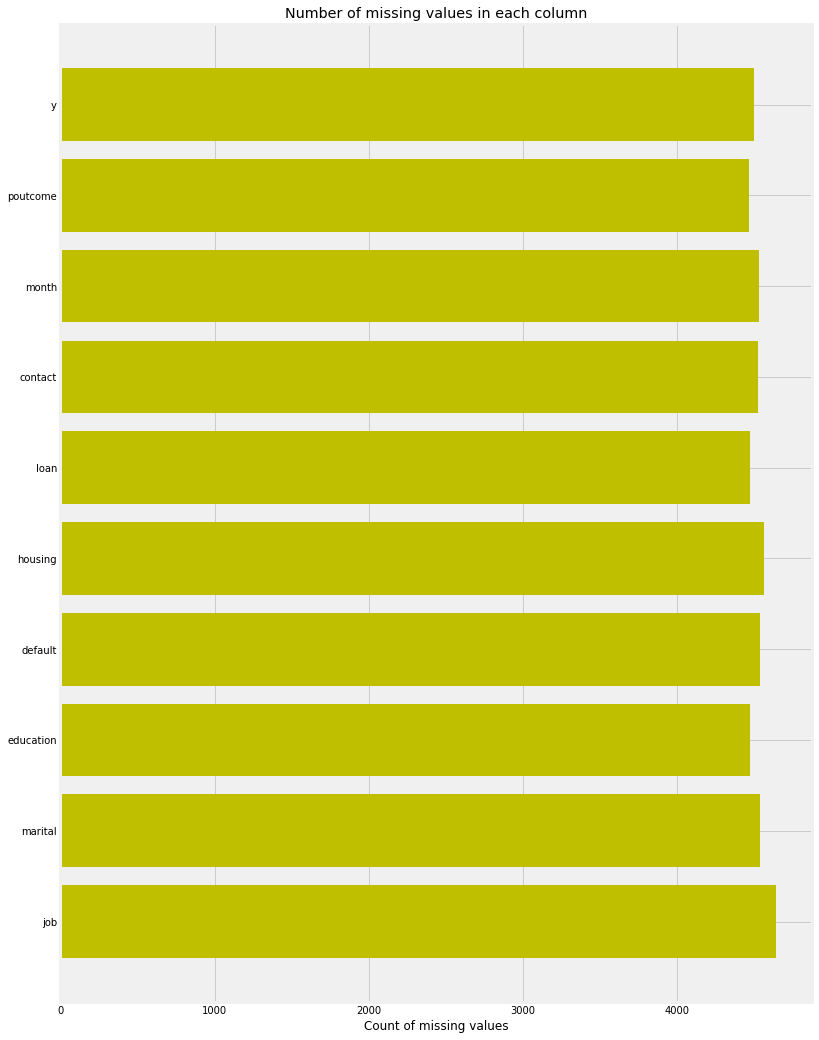

In [57]:
show_missing_values(input_df)

### Classification Algorithm Implementation

1. Logistic Regression
2. Random Forests
3. KNeighborsClassifier
4. Gaussian Naive Bayes
5. Support Vector Machines

Finally, we will find the correlation coefficient for each feature using Logistic Regression


In [25]:
input_df_predictor = input_df.drop("y", axis=1)
input_df_target = input_df["y"]
print("predictor of input dataset shape: {shape}".format(shape=input_df_predictor.shape))
print("predictor of target dataset shape: {shape}".format(shape=input_df_target.shape))

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(input_df_predictor, input_df_target, test_size=0.2, random_state=42)
print("\n")
print("Training set Predictor (data) shape: {shape}".format(shape=X_train.shape))
print("Training set Test(data) shape: {shape}".format(shape=X_test.shape))
print("\n")
print("Test set Predictor (data) shape: {shape}".format(shape=X_train.shape))
print("Test set target(data) shape: {shape}".format(shape=X_test.shape))

predictor of input dataset shape: (45211, 16)
predictor of target dataset shape: (45211,)


Training set Predictor (data) shape: (36168, 16)
Training set Test(data) shape: (9043, 16)


Test set Predictor (data) shape: (36168, 16)
Test set target(data) shape: (9043, 16)


In [26]:
def predict_classification(classifier, X_train, Y_train, X_test):
    '''
    A method for doing the classification of data using the machine learning scikit learn methods
    
    Steps:
        1. train the classifier
        2. predict the classifier
        3. Find out the accuracy of the training data set and test data set
        
    Argument:
    Classifier -- Name of the classifier
    X_train -- Training predictor data
    Y_train -- Training Label data
    X_test -- Testing Predictor data
    
    Return:
    predicted value of the classifier
    '''
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)
    return (Y_train_pred, Y_test_pred)

In [27]:
def calculate_score(classifier, X_train, Y_train, X_test, Y_test):
    '''
    Calculate train, test score of the machine learning classifier
    
    Argument:
    Classifier -- Name of the classifier
    X_train -- Training predictor data
    Y_train -- Training Label data
    X_test  -- Testing Predictor data
    Y_test  -- Testing Label data
    
    Return: 
    a tuple of (train_score, test_error)
    train_score: accuracy of the train dataset
    test_score: accuracy of test dataset
    '''
    
    train_score = classifier.score(X_train, Y_train)
    test_score = classifier.score(X_test, Y_test)
    return (train_score, test_score)

In [28]:
def calculate_roc_score(Y_train, train_pred, test_pred, Y_test):
    '''
    Argument:
    Classifier -- Name of the classifier
    X_train -- Training predictor data
    Y_train -- Training Label data
    X_test  -- Testing Predictor data
    Y_test  -- Testing Label data
    calculate ROC curve:
    https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it


    '''
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    print ('roc auc train logistic regression: {roc_auc_train}'.format(roc_auc_train= roc_auc_train ))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, test_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    print ('roc auc train logistic regression: {roc_auc_test}'.format(roc_auc_test= roc_auc_test ))

We can crosscheck our feature engineering using Logistic Regression. This can be done by calculating the coefficient of the features.

Positive Coefficients mean there is a directly proportional to the survived where negative is inversely proportional.

In [29]:
def find_corr_values(classifier):
    '''
    Use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals.  
    Argument:
    classifier -- Name of the classifier
    
    Return:
    ordered dataframe containing feature name and value
    '''
    coeff_df = pd.DataFrame(X_train.columns.delete(0))
    coeff_df.columns = ['Feature']

    coeff_df['Correlation'] = pd.Series(classifier.coef_[0])
    coeff_df.sort_values(by='Correlation', ascending=False)
    return coeff_df

As we noticed default has most impact on the target value=1 where loan has most negative impact

In [30]:
classifier = LogisticRegression(class_weight='balanced')
predicted_train_value, predicted_test_value = predict_classification(classifier, 
                                                                     X_train= X_train, 
                                                                     Y_train= Y_train, 
                                                                     X_test= X_test)
train_error, test_error = calculate_score(classifier, X_train= X_train, Y_train= Y_train, X_test= X_test, Y_test= Y_test)
print("Training error : {train_error}".format(train_error=train_error))
print("Test error : {test_error}".format(test_error=test_error))
calculate_roc_score(Y_train= Y_train, train_pred= predicted_train_value, 
                   test_pred= predicted_test_value, Y_test= Y_test)

find_corr_values(classifier=classifier)

Training error : 0.8079517805795178
Test error : 0.8048214088245051
roc auc train logistic regression: 0.8035253989156997
roc auc train logistic regression: 0.806774711052751


,Feature,Correlation
0,job,0.007362
1,marital,0.009872
2,education,0.196587
3,default,0.209026
4,balance,-0.496228
5,housing,0.000024
6,loan,-1.155360
7,contact,-0.753951
8,day,-0.707818
9,month,-0.007113


In [31]:
classifier = RandomForestClassifier(n_estimators=100, class_weight= 'balanced')
predicted_value = predict_classification(classifier,
                                         X_train= X_train,
                                         Y_train= Y_train,
                                         X_test= X_test)
train_error, test_error = calculate_score(classifier, X_train= X_train, Y_train=Y_train, X_test= X_test, Y_test=Y_test)
print("Training error : {train_error}".format(train_error=train_error))
print("Test error : {test_error}".format(test_error=test_error))
calculate_roc_score(Y_train= Y_train, train_pred= predicted_train_value, 
                   test_pred= predicted_test_value, Y_test= Y_test)



Training error : 0.999944702499447
Test error : 0.8991485126617274
roc auc train logistic regression: 0.8035253989156997
roc auc train logistic regression: 0.806774711052751


In [32]:
classifier = KNeighborsClassifier(n_neighbors=3)
predicted_value = predict_classification(classifier, 
                                         X_train= X_train,
                                         Y_train= Y_train,
                                         X_test= X_test)
train_error, test_error = calculate_score(classifier, X_train= X_train, Y_train=Y_train, X_test= X_test, Y_test=Y_test)
print("Training error : {train_error}".format(train_error=train_error))
print("Test error : {test_error}".format(test_error=test_error))
calculate_roc_score(Y_train= Y_train, train_pred= predicted_train_value, 
                   test_pred= predicted_test_value, Y_test= Y_test)

Training error : 0.9241318292413183
Test error : 0.8713922370894615
roc auc train logistic regression: 0.8035253989156997
roc auc train logistic regression: 0.806774711052751


In [33]:
classifier = GaussianNB()
predicted_value = predict_classification(classifier,
                                         X_train= X_train,
                                         Y_train= Y_train,
                                         X_test= X_test)
train_error, test_error = calculate_score(classifier, X_train= X_train, Y_train=Y_train, X_test= X_test, Y_test=Y_test)
print("Training error : {train_error}".format(train_error=train_error))
print("Test error : {test_error}".format(test_error=test_error))
calculate_roc_score(Y_train= Y_train, train_pred= predicted_train_value, 
                   test_pred= predicted_test_value, Y_test= Y_test)

Training error : 0.8393607608936076
Test error : 0.8289284529470309
roc auc train logistic regression: 0.8035253989156997
roc auc train logistic regression: 0.806774711052751


In [34]:
svm_clf = Pipeline((
          ("scalar", preprocessing.StandardScaler()),
          ("linear_svc", LinearSVC(C=1, loss="hinge", class_weight= 'balanced'))
    ))

svm_clf.fit(X_train, Y_train)

predicted_train_value = svm_clf.predict(X_train)
predicted_test_value = svm_clf.predict(X_test)

print("Training error : {train_error}".format(train_error=train_error))
print("Test error : {test_error}".format(test_error=test_error))
calculate_roc_score(Y_train= Y_train, train_pred= predicted_train_value, 
                   test_pred= predicted_test_value, Y_test= Y_test)

Training error : 0.8393607608936076
Test error : 0.8289284529470309
roc auc train logistic regression: 0.8052831732583982
roc auc train logistic regression: 0.8053661681362233
